# Model Based Machine Learning Project

We have chosen to work with a dataset on Life Expectancy collected by (WHO).

In the first part of this script we do some data cleaning/preperation and initial statistical analysis.  

## Loadning and visualizing the data 

We start by importing packages.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib as mplib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import linear_model
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [16]:
data = pd.read_csv("archive/addtional_infor_life.csv")
LED = pd.DataFrame(data)

In [17]:
LED.head(5)

,Unnamed: 0.1,Unnamed: 0,Country,continent,Life expectancy,Year,Status,Adult Mortality,infant deaths,Alcohol,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,0.0,Afghanistan,Asia,65.0,2015.0,0.0,263.0,62.0,0.01,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,1,1.0,Afghanistan,Asia,59.9,2014.0,0.0,271.0,64.0,0.01,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2,2.0,Afghanistan,Asia,59.9,2013.0,0.0,268.0,66.0,0.01,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,3,3.0,Afghanistan,Asia,59.5,2012.0,0.0,272.0,69.0,0.01,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,4,4.0,Afghanistan,Asia,59.2,2011.0,0.0,275.0,71.0,0.01,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [18]:
# Replace 'developed' with 1 and 'developing' with 0
#LED['Status'] = LED['Status'].map({'Developed': 1, 'Developing': 0})
# Convert the column to integer type
#LED['Status'] = LED['Status'].astype(int)

LED = LED.drop(['Unnamed: 0.1', 'Unnamed: 0'],axis=1)

#LED.head(5)

In [19]:
print(LED.info())
#print(data_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   continent                        2938 non-null   object 
 2   Life expectancy                  2928 non-null   float64
 3   Year                             2938 non-null   float64
 4   Status                           2938 non-null   float64
 5   Adult Mortality                  2928 non-null   float64
 6   infant deaths                    2938 non-null   float64
 7   Alcohol                          2744 non-null   float64
 8   percentage expenditure           2938 non-null   float64
 9   Hepatitis B                      2385 non-null   float64
 10  Measles                          2938 non-null   float64
 11   BMI                             2904 non-null   float64
 12  under-five deaths   

In [20]:
LED.dropna(inplace=True)
print(LED.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859 entries, 0 to 2937
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1859 non-null   object 
 1   continent                        1859 non-null   object 
 2   Life expectancy                  1859 non-null   float64
 3   Year                             1859 non-null   float64
 4   Status                           1859 non-null   float64
 5   Adult Mortality                  1859 non-null   float64
 6   infant deaths                    1859 non-null   float64
 7   Alcohol                          1859 non-null   float64
 8   percentage expenditure           1859 non-null   float64
 9   Hepatitis B                      1859 non-null   float64
 10  Measles                          1859 non-null   float64
 11   BMI                             1859 non-null   float64
 12  under-five deaths   

array([[<Axes: title={'center': 'Life expectancy '}>,
        <Axes: title={'center': 'Status'}>,
        <Axes: title={'center': 'Adult Mortality'}>],
       [<Axes: title={'center': 'infant deaths'}>,
        <Axes: title={'center': 'Alcohol'}>,
        <Axes: title={'center': 'percentage expenditure'}>],
       [<Axes: title={'center': 'Hepatitis B'}>,
        <Axes: title={'center': 'Measles '}>,
        <Axes: title={'center': ' BMI '}>],
       [<Axes: title={'center': 'under-five deaths '}>,
        <Axes: title={'center': 'Polio'}>,
        <Axes: title={'center': 'Total expenditure'}>],
       [<Axes: title={'center': 'Diphtheria '}>,
        <Axes: title={'center': ' HIV/AIDS'}>,
        <Axes: title={'center': 'GDP'}>],
       [<Axes: title={'center': 'Population'}>,
        <Axes: title={'center': ' thinness  1-19 years'}>,
        <Axes: title={'center': ' thinness 5-9 years'}>],
       [<Axes: title={'center': 'Income composition of resources'}>,
        <Axes: title={'ce

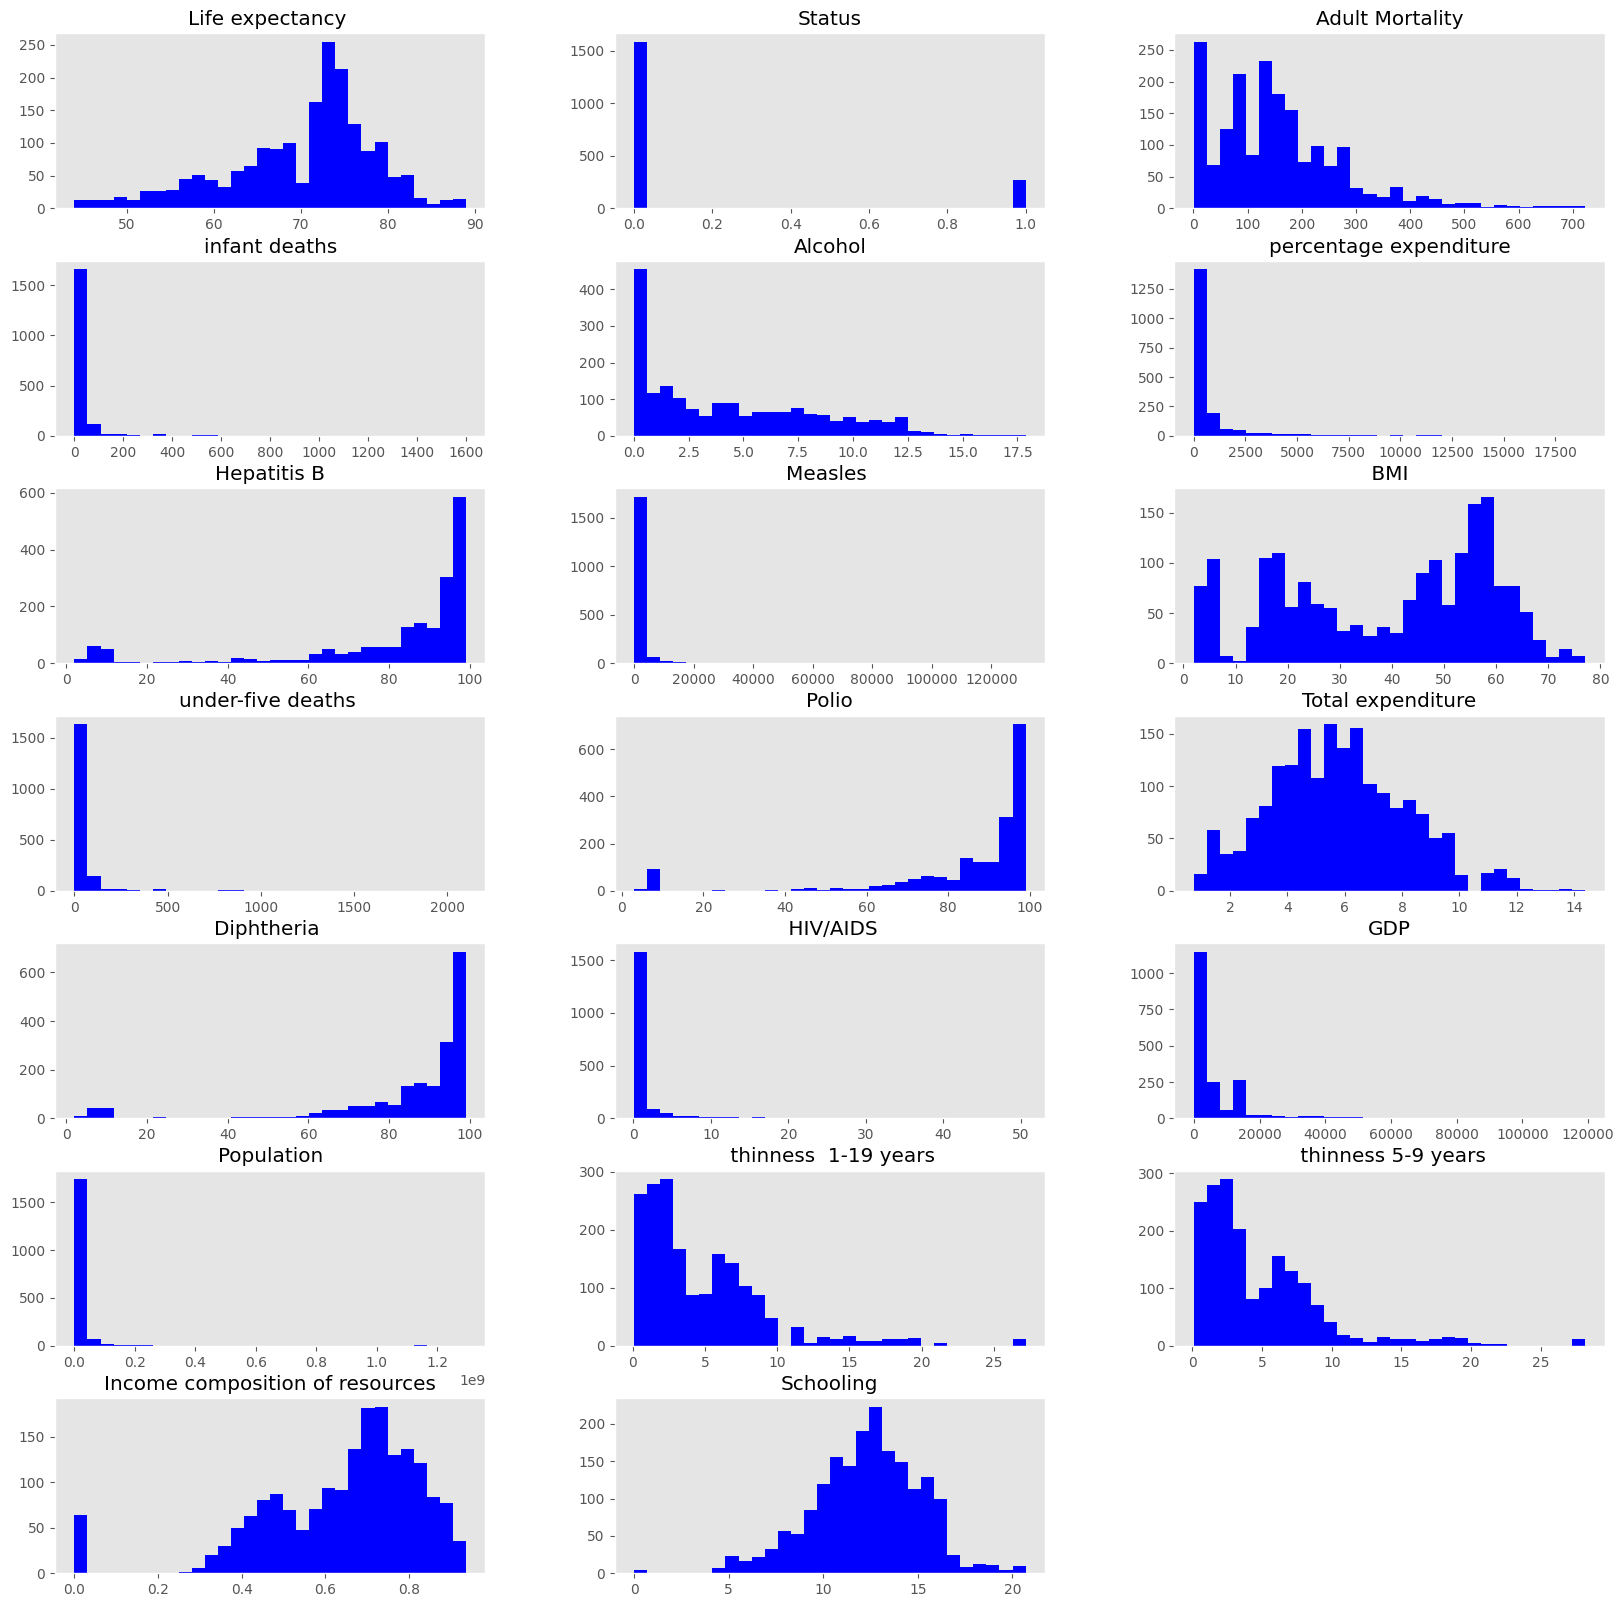

In [21]:
#Plotting histograms of all data.

# Select only numerical columns
num_cols = LED.select_dtypes(include=['int64', 'float64']).drop('Year', axis=1)

# Plot histograms for all numerical columns in a grid
num_cols.hist(figsize=(20,20), bins=30, grid=False, layout=(7,3), color='b')

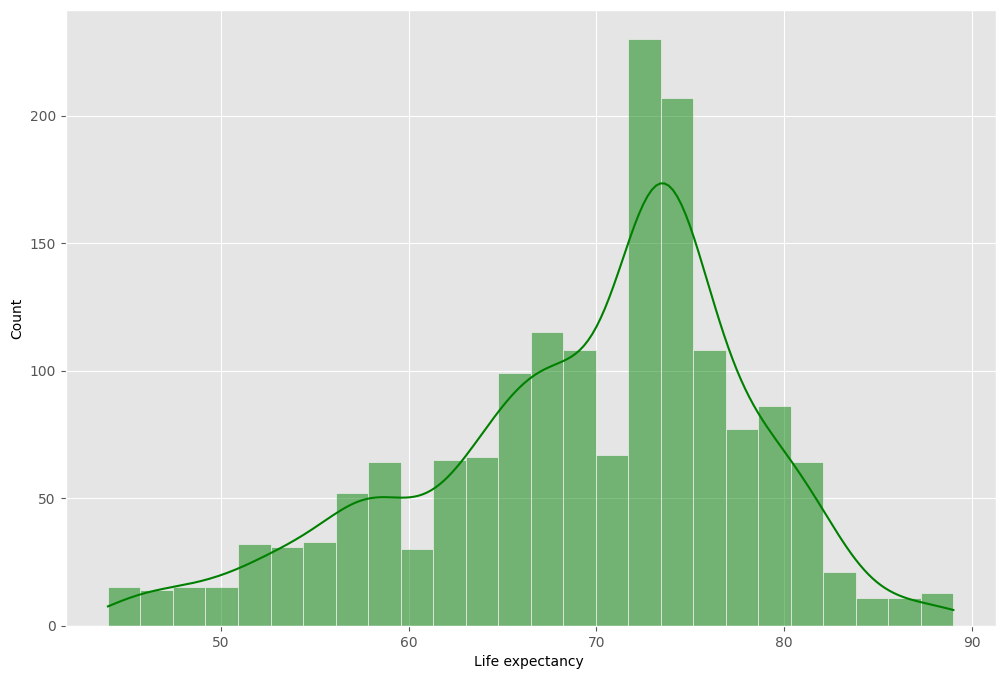

In [12]:
sns.histplot(data=LED, x='Life expectancy ',kde=True, color = 'green')
plt.show()

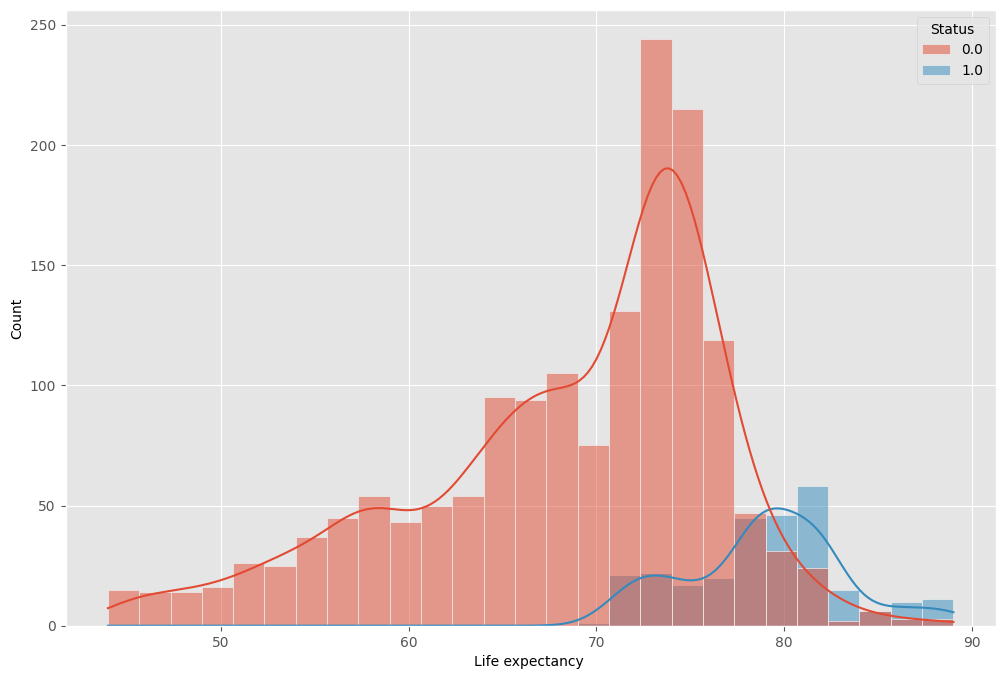

In [22]:
sns.histplot(data=LED, x='Life expectancy ', hue='Status', kde=True)
plt.show()

C:\Users\Magnus\AppData\Local\Temp\ipykernel_13448\3699636491.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = LED.corr()


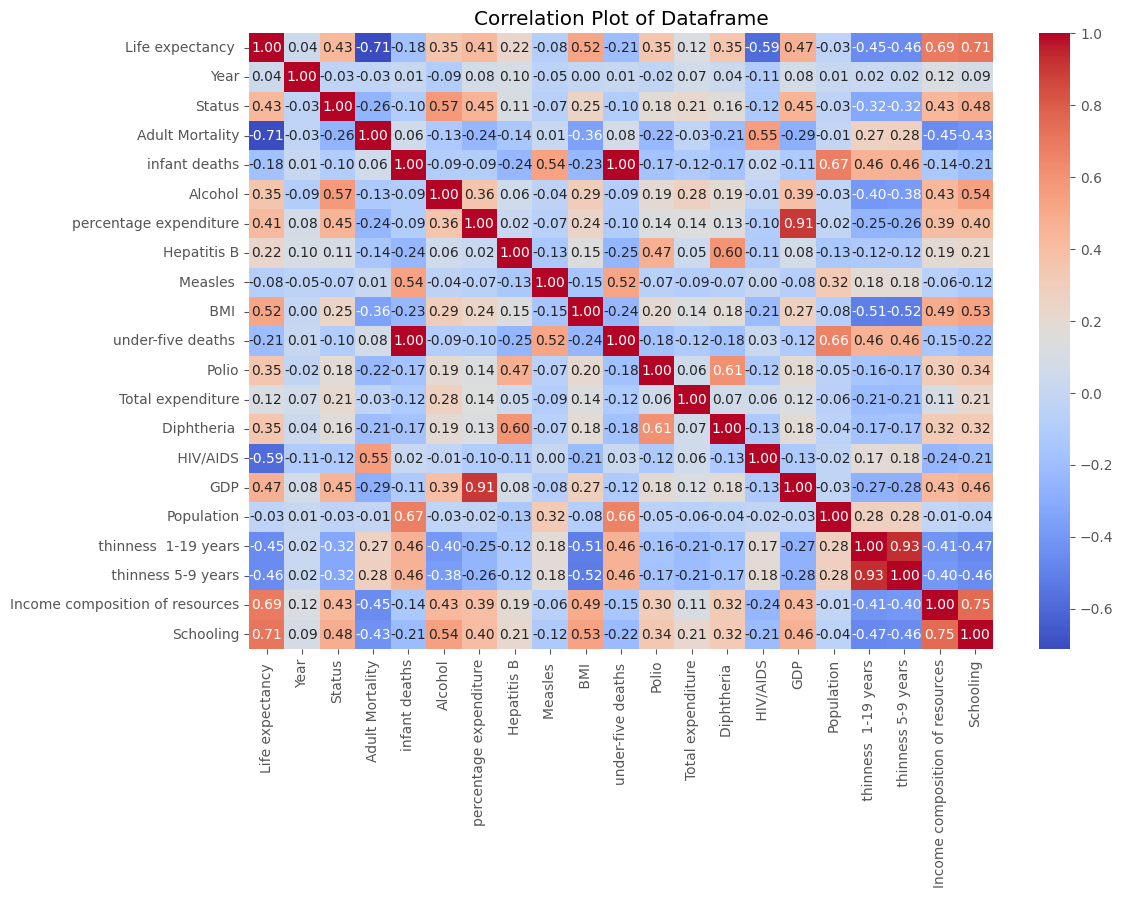

In [23]:
# Compute the correlation matrix
corr_matrix = LED.corr()

plt.figure(figsize=(12, 8))

# Plot the correlation matrix using seaborn heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Plot of Dataframe')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


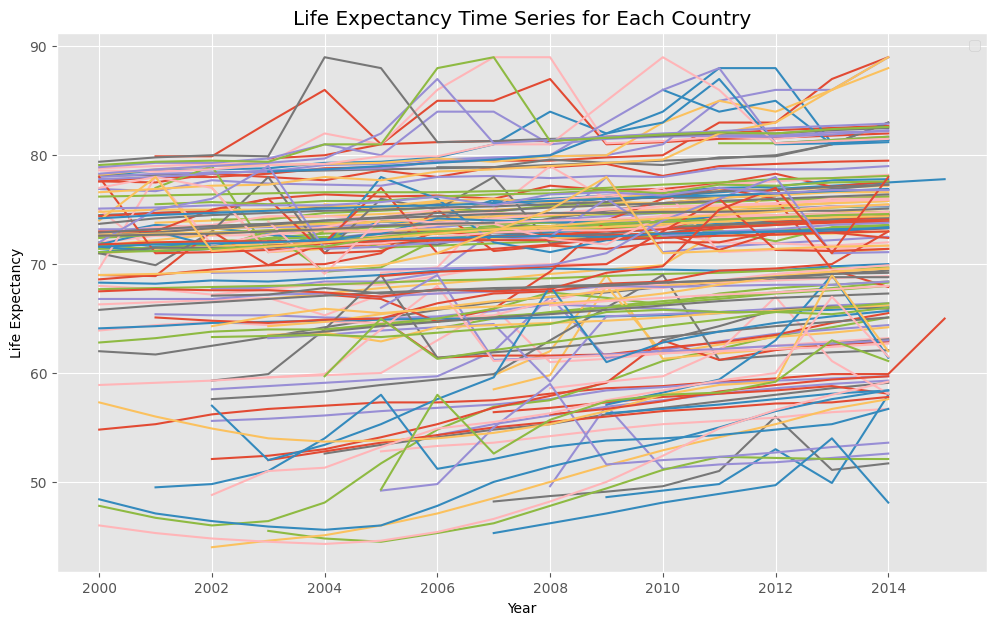

In [24]:
# Group the data by country
grouped = LED.groupby('Country')

# Set the size of the plot
plt.figure(figsize=(12,7))

# Plot the time series for each country
for country, group in grouped:
    plt.plot(group['Year'], group['Life expectancy '])

# Add legend to the plot
plt.legend()

# Set axis labels and title of the plot
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy Time Series for Each Country')

plt.show()

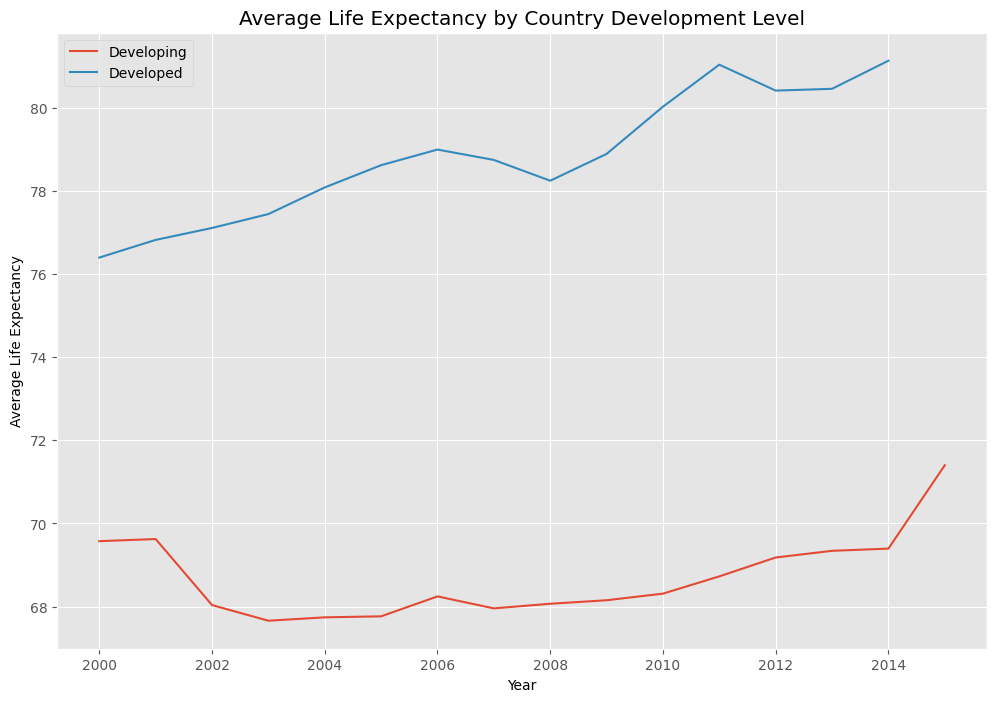

In [25]:
# Group by 'Status' and 'year', and take the average of 'life_expectancy'
LED_grouped = LED.groupby(['Status', 'Year'])['Life expectancy '].mean()

# Convert the grouped dataframe to a wide format with 'year' as the index
LED_pivot = LED_grouped.unstack(level=0)

# Plot the resulting dataframe as a time series
LED_pivot.plot(kind='line')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy')
plt.title('Average Life Expectancy by Country Development Level')
# Add legend to the plot
plt.legend(labels=['Developing','Developed'])

# Show the plot
plt.show()


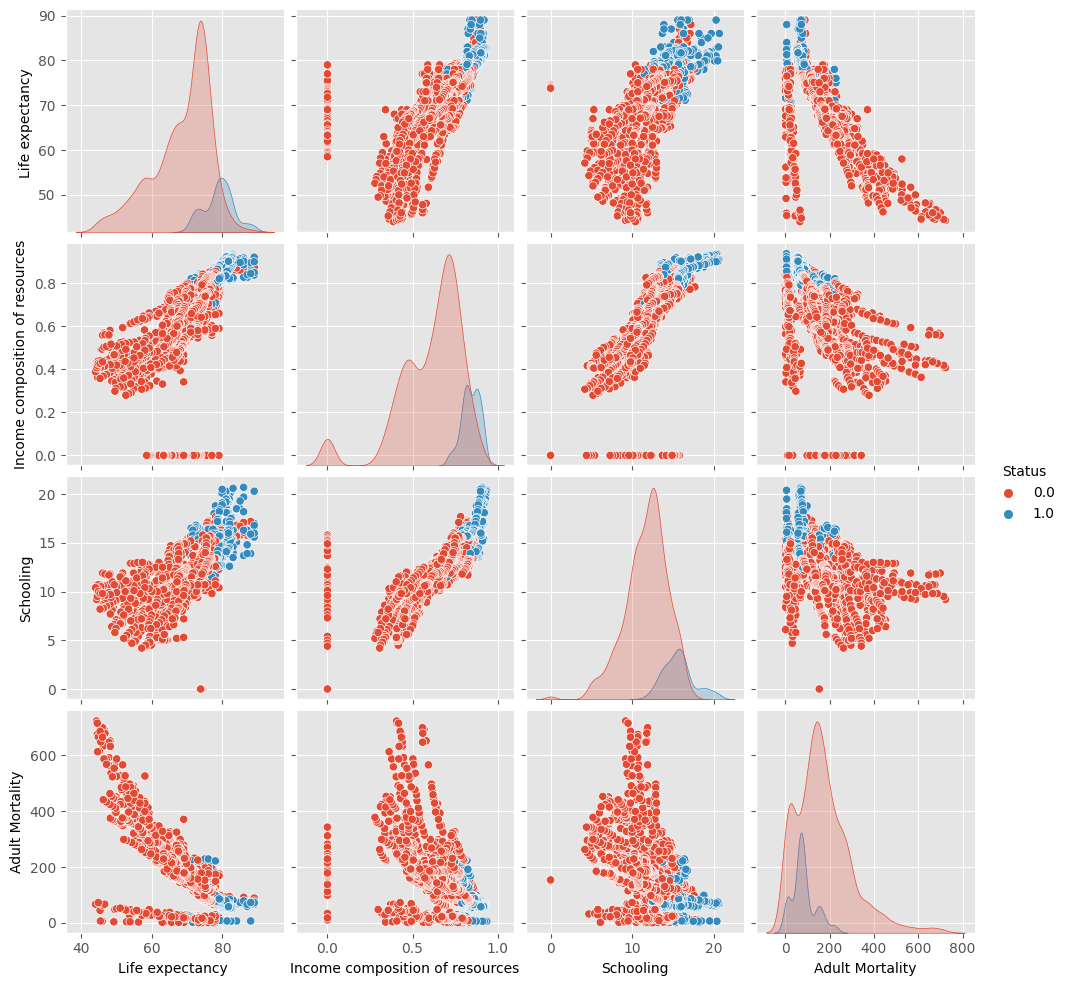

In [26]:
# Select columns to plot
groups_to_plot = ['Life expectancy ','Income composition of resources','Schooling','Adult Mortality']  
# Create scatter plot matrix
sns.pairplot(LED,vars = groups_to_plot, hue ='Status',)

## Setting up Pyro model

In [27]:
LED.head(5)

,Country,continent,Life expectancy,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,Asia,65.0,2015.0,0.0,263.0,62.0,0.01,71.279624,65.0,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,Asia,59.9,2014.0,0.0,271.0,64.0,0.01,73.523582,62.0,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,Asia,59.9,2013.0,0.0,268.0,66.0,0.01,73.219243,64.0,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,Asia,59.5,2012.0,0.0,272.0,69.0,0.01,78.184215,67.0,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,Asia,59.2,2011.0,0.0,275.0,71.0,0.01,7.097109,68.0,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [41]:
mat = LED.values
X = np.array(mat[:,3:],float) #These are the regressors
print(X.shape)

y_original = np.array(mat[:,2],float) #This is the target variable life expectancy
print(y.shape)

ind = mat[:,1] #These are the hierarchies
print(ind.shape)

(1859, 20)
(1859,)
(1859,)


In [45]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# standardize target
y_mean = y_original.mean()
y_std = y_original.std()
y = (y_original - y_mean) / y_std

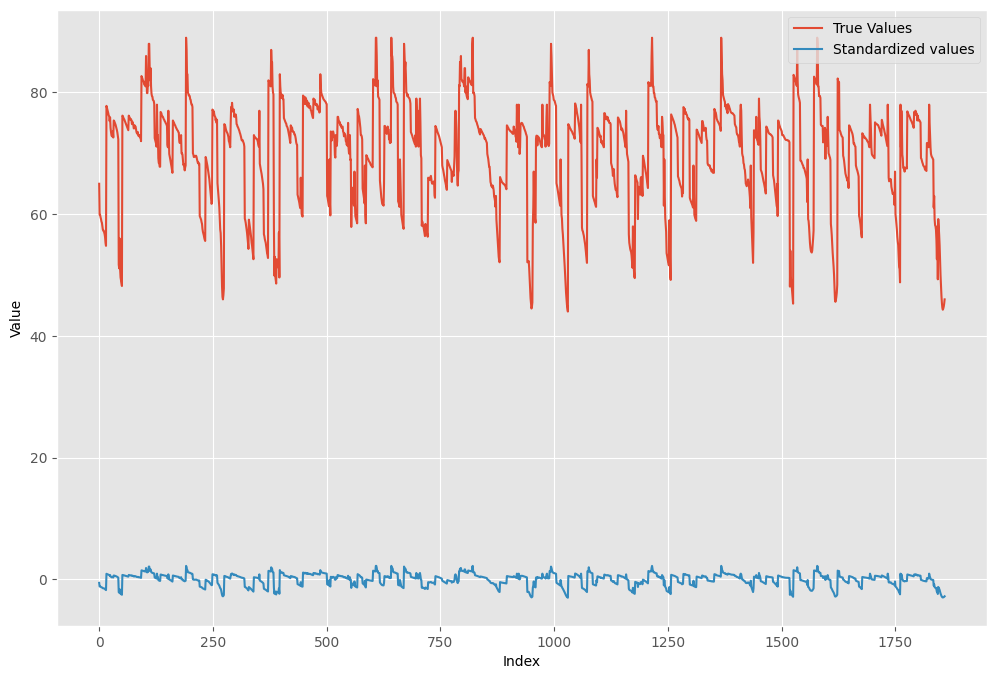

In [47]:
plt.plot(y_original, label='True Values')
plt.plot(y, label='Standardized values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [66]:
#Setup split for traning and test data set. We will use 2000-2012 as traning and 2013-2015 as test. 

training_idx = (LED['Year'] >= 2000) & (LED['Year'] <= 2012)
test_idx = (LED['Year'] >= 2013) & (LED['Year'] <= 2015)

X_train = X[training_idx,:]
X_test = X[test_idx,:]

y_train = y[training_idx]
y_test = y[test_idx]

ind_train = ind[training_idx]
ind_test  = ind[test_idx]

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1566
num test: 293


In [49]:
#Function borrowed form lecture 05 to calculate standard error measures. 

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [50]:
#regr = linear_model.LinearRegression()
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.907
MAE: 2.769
RMSE: 3.593
R2: 0.810


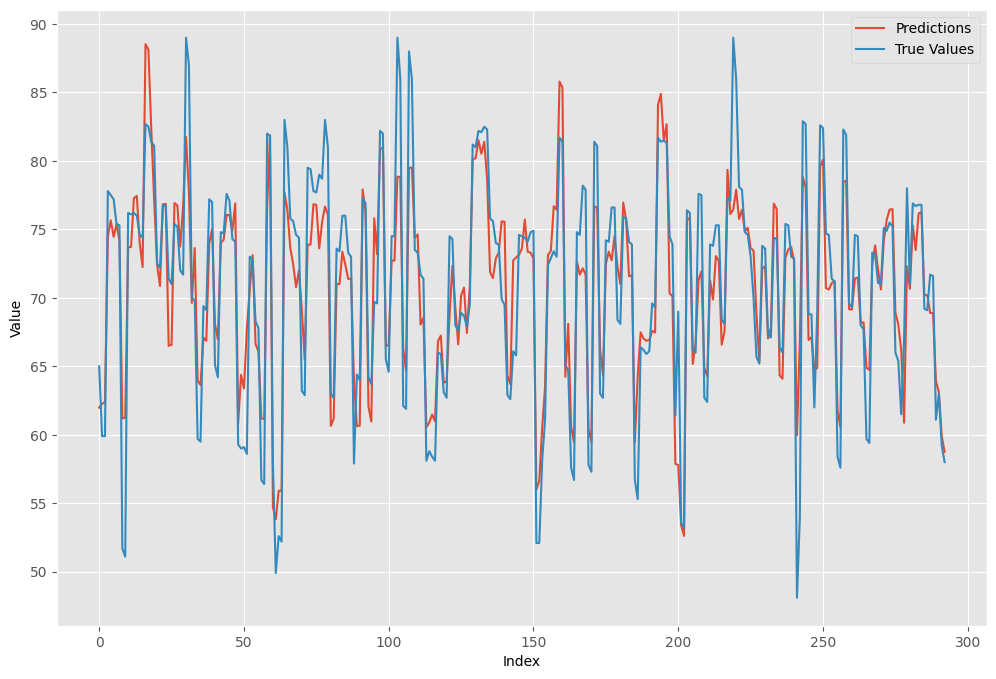

In [51]:
#Plotting predictions vs true values in original domain 
plt.plot(preds, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [52]:
#Implementation in Pyro of Baysian liear regression with intercept alpha

def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [53]:
#Convert to format pyro can read 
X_train_pyro = torch.tensor(X_train).float()
y_train_pyro = torch.tensor(y_train).float()

# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_pyro, y_train_pyro)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [04:03,  4.93it/s, step size=6.53e-02, acc. prob=0.934]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.01      0.01     -0.01     -0.02      0.01   2019.37      1.00
   beta[0]     -0.06      0.01     -0.06     -0.08     -0.04   1514.80      1.00
   beta[1]      0.04      0.01      0.04      0.02      0.06   1039.92      1.00
   beta[2]     -0.24      0.01     -0.24     -0.26     -0.21   1452.20      1.00
   beta[3]      1.30      0.14      1.30      1.07      1.53    411.36      1.00
   beta[4]     -0.02      0.02     -0.02     -0.05      0.00    835.92      1.00
   beta[5]      0.03      0.03      0.02     -0.02      0.07    827.86      1.00
   beta[6]      0.00      0.01      0.00     -0.02      0.02   1447.88      1.00
   beta[7]     -0.02      0.01     -0.02     -0.04      0.00   1441.34      1.00
   beta[8]      0.06      0.01      0.06      0.04      0.08   1602.45      1.00
   beta[9]     -1.31      0.14     -1.32     -1.54     -1.09    409.50      1.00
  beta[10]      0.02      0

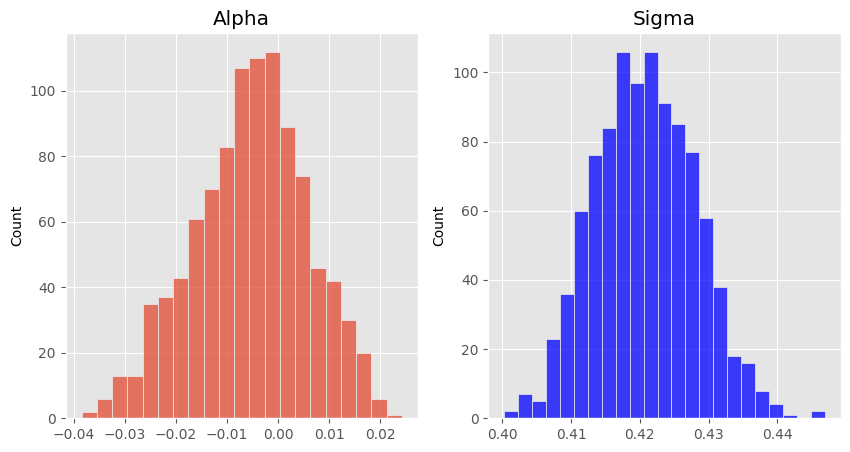

In [54]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

#Create 2x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#plot alpha value
sns.histplot(posterior_samples["alpha"], ax=axs[0])
axs[0].set_title('Alpha')

#plot sigma 
sns.histplot(posterior_samples["sigma"], ax=axs[1],color='blue')
axs[1].set_title('Sigma')

# display the figure
plt.show()


In [55]:
#Next we want to test the error measures 

print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

y_hat = alpha_hat+np.dot(X_test,beta_hat)


torch.Size([1000])
torch.Size([1000, 20])


In [56]:
# Convert back to the original scale
preds = y_hat.numpy() * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.906
MAE: 2.780
RMSE: 3.599
R2: 0.809


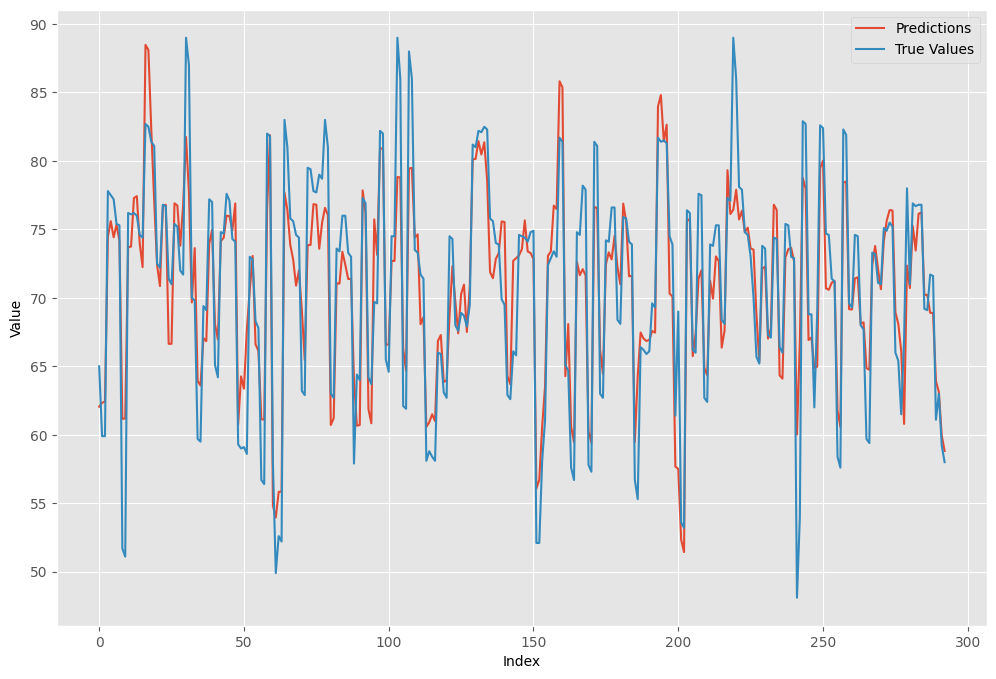

In [57]:
#Plotting predictions vs true values in original domain 
plt.plot(preds, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## Notes

Regarding approx inf method: Using MCMC or SVI is is a question of modes. MCMC is more comp. expensive but can get to a distribution closer to the target. 

MCMC: remember to look at trace plot to see if the chain has converged. 

Missing values: 
- We can try to go out and find the missing values 
- Drop all 
- Drop data by continents 

## Moving to Hierarchical models

In [58]:
#Implementation in Pyro of Baysian liear regression with intercept alpha

def model(X,continents, obs=None):
    n_ind = 7
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.)) 
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(5.)) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                              # Prior for the variance

    with pyro.plate("continents", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) # Draw the individual parameter for each individual

    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha[continents] + X.matmul(beta), sigma), obs=obs)
        
    return y

In [59]:
#print(LED['continent'].unique())

#Creat map from continet to index
continent_dict = {'Asia': 0, 'Europe': 1, 'Africa': 2, 'Americas': 3, 'Oceania': 4}

# using the map to create np array with indecies 
continent_idx = np.array(LED.loc[training_idx,'continent'].map(continent_dict))


len(continent_idx)

1566

In [60]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_pyro,continent_idx, y_train_pyro)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [08:39,  2.31it/s, step size=5.14e-02, acc. prob=0.951]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha[0]      0.05      0.02      0.05      0.02      0.10    624.10      1.00
     alpha[1]      0.05      0.04      0.05     -0.00      0.11    663.46      1.00
     alpha[2]     -0.28      0.03     -0.28     -0.32     -0.23    530.77      1.00
     alpha[3]      0.26      0.03      0.26      0.21      0.30    734.05      1.00
     alpha[4]     -0.09      0.04     -0.09     -0.16     -0.03   1027.24      1.00
     alpha[5]     -0.03      0.41     -0.00     -0.60      0.59    364.10      1.00
     alpha[6]      0.00      0.38      0.00     -0.57      0.61    358.30      1.00
     alpha_mu     -0.01      0.16     -0.01     -0.23      0.25    607.52      1.00
  alpha_sigma      0.31      0.20      0.25      0.12      0.55    217.08      1.00
      beta[0]     -0.03      0.01     -0.03     -0.05     -0.01    901.49      1.00
      beta[1]      0.09      0.02      0.09      0.06      0.11    705.60  

In [72]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

#Creat map from continet to index
continent_dict = {'Asia': 0, 'Europe': 1, 'Africa': 2, 'Americas': 3, 'Oceania': 4}

# using the map to create np array with indecies 
continent_idx_test = np.array(LED.loc[test_idx,'continent'].map(continent_dict))

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

y_hat = alpha_hat[continent_idx_test] + np.dot(X_test,beta_hat)

torch.Size([1000, 7])
torch.Size([1000, 20])


In [73]:
# Convert back to the original scale
preds = y_hat.numpy() * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.917
MAE: 2.585
RMSE: 3.346
R2: 0.835


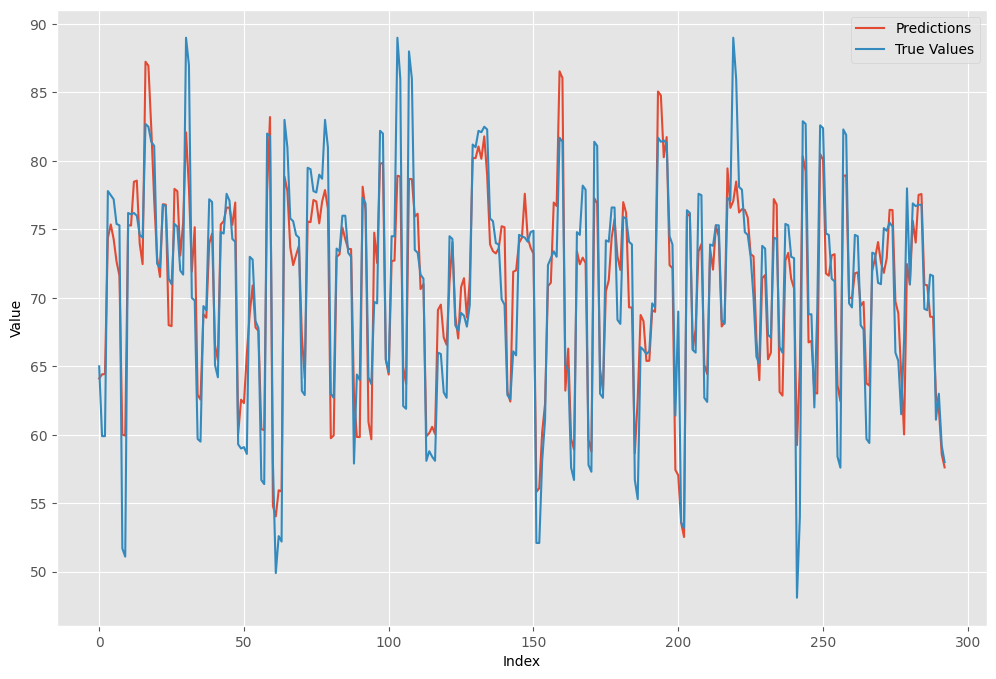

In [74]:
#Plotting predictions vs true values in original domain 
plt.plot(preds, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## Moving to both alpha and beta hierarical

In [100]:
#Implementation in Pyro of Baysian liear regression with intercept alpha

def model(X,continents, obs=None):
    n_ind = 7
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.)) 
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(5.)) # Prior for the bias standard deviation
    
    beta_mu = pyro.sample("beta_mu", dist.Normal(0., 1.)) 
    beta_sigma  = pyro.sample("beta_sigma", dist.HalfCauchy(5.)) # Prior for the bias standard deviation

    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                              # Prior for the variance

    with pyro.plate("continents", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) # Draw the individual parameter for each individual

        beta = pyro.sample("beta", dist.Normal(beta_mu*torch.ones(X.shape[1]), 
                                               beta_sigma*torch.ones(X.shape[1])).to_event(1)) # Draw the individual parameter for each individual

    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha[continents] + X.matmul(beta[continents].T), sigma), obs=obs)
        
    return y

In [85]:
X.shape[1]

20

In [101]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_pyro,continent_idx, y_train_pyro)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [2:38:10,  7.91s/it, step size=1.42e-03, acc. prob=0.712]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha[0]      0.08      0.00      0.08      0.08      0.08     53.90      1.00
     alpha[1]      0.76      0.00      0.76      0.76      0.76     29.50      1.07
     alpha[2]     -1.14      0.00     -1.14     -1.14     -1.13     26.08      1.06
     alpha[3]      0.45      0.00      0.45      0.45      0.45     25.74      1.03
     alpha[4]      0.15      0.00      0.15      0.15      0.15     14.60      1.01
     alpha[5]     -0.01      0.05     -0.01     -0.08      0.06      4.09      1.10
     alpha[6]      0.89      0.01      0.89      0.88      0.90      3.58      1.74
     alpha_mu     -0.65      0.04     -0.63     -0.71     -0.60      6.02      1.30
  alpha_sigma      1.15      0.06      1.12      1.09      1.24      2.75      2.19
    beta[0,0]      0.00      0.00      0.00     -0.00      0.00    170.85      1.01
    beta[0,1]     -0.00      0.00     -0.00     -0.00      0.00    129.15  

In [174]:
posterior_samples_hh = mcmc.get_samples()

beta_hat_hh=torch.mean(posterior_samples_hh["beta"], axis=0)
alpha_hat_hh=torch.mean(posterior_samples_hh["alpha"], axis=0)

beta_hat_hh.size()

multi_row = np.multiply(X_test,beta_hat_hh[continent_idx_test,:])
beta_part = torch.sum(multi_row,dim=1)

y_hat = alpha_hat_hh[continent_idx_test] + beta_part

In [175]:
# Convert back to the original scale
preds = y_hat.numpy() * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.731
MAE: 4.587
RMSE: 5.873
R2: 0.492


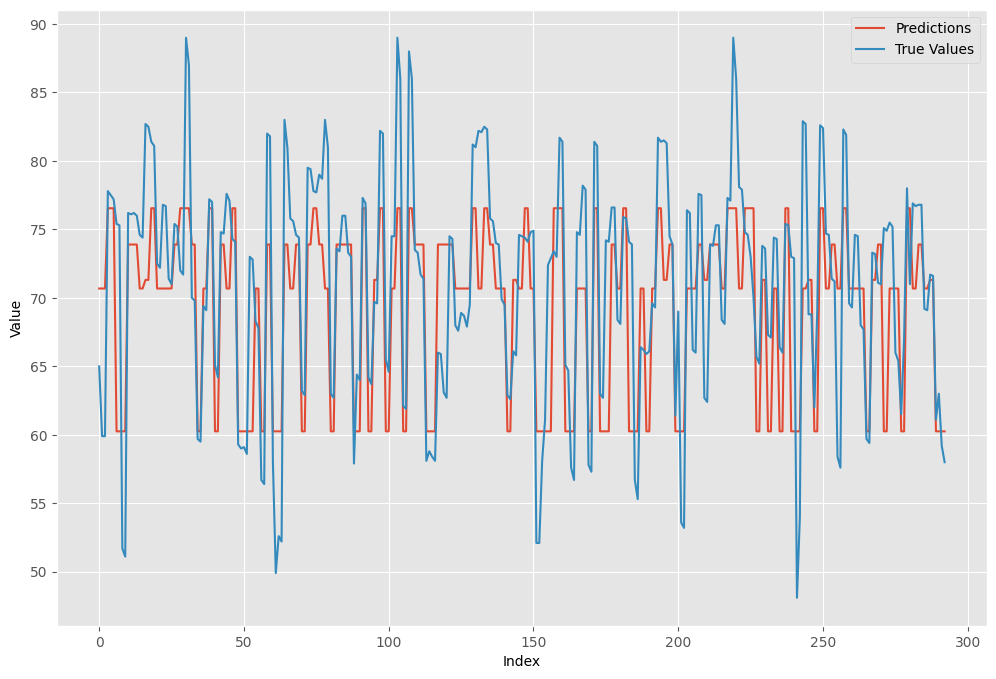

In [176]:
#Plotting predictions vs true values in original domain 
plt.plot(preds, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [108]:
#Save output from MCMC
import os

current_directory = os.getcwd()
file_name = "mcmc_samples.npy"
file_path = os.path.join(current_directory, file_name)

# Save samples to a file
np.save(file_path, posterior_samples_hh)
loaded_samples = np.load(file_path, allow_pickle=True)

loaded_samples.item()["alpha"]